### Visualizing Responses

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

X = np.load('pt2/X_data.npy', mmap_mode='r')
y = np.load('pt2/Y_data.npy', mmap_mode='r')



In [ ]:
# ...existing code...
responses = X[0:25]
fig, axes = plt.subplots(nrows= 5, ncols=5, figsize=(15,15))
for i,ax in enumerate(axes.flatten()):
    t = responses[i][:, 2]
    x_e = responses[i][:, 0]
    x_a = responses[i][:, 1]
    K = y[i][0]
    T1 = y[i][1]
    T2 = y[i][2]
    ax.plot(t, x_e, label='x_e')
    ax.plot(t, x_a, label='x_a')
    ax.set_title(f'K={K}, T1={T1}, T2={T2}')
    ax.set_xlabel('Time (t)')
    ax.set_ylabel('Amplitude')

plt.tight_layout() # Adjust subplot params for a tight layout
plt.show() # Display the figure

### Parameters 

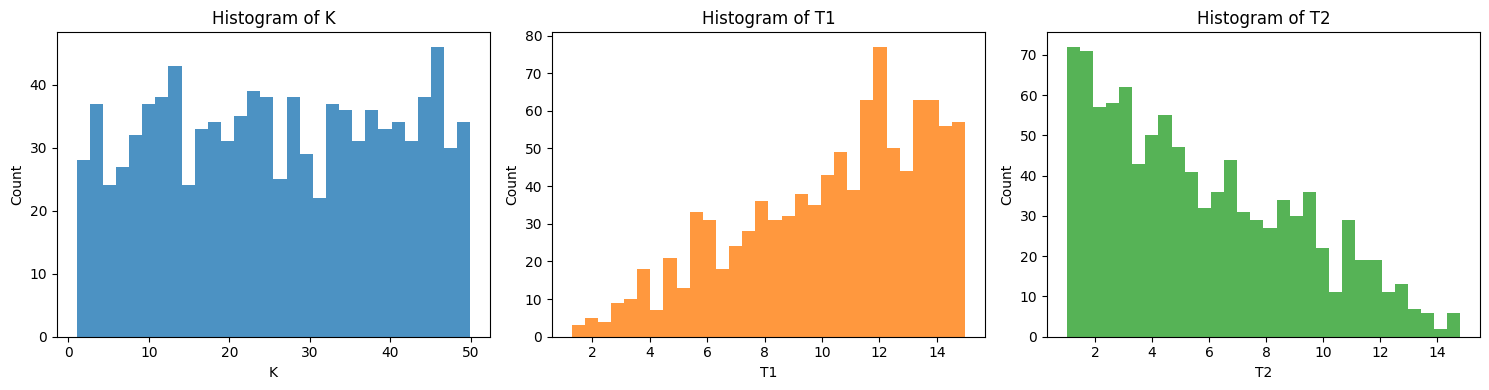

In [3]:
import numpy as np
import matplotlib.pyplot as plt

y = np.load('pt2/Y_data.npy', allow_pickle=True)
y = np.asarray(y, dtype=float)  # ensure numeric array, shape (N,3)

labels = ['K', 'T1', 'T2']
fig, axes = plt.subplots(1, 3, figsize=(15,4))
for i, ax in enumerate(axes):
    ax.hist(y[:, i], bins=30, color=f'C{i}', alpha=0.8)
    ax.set_title(f'Histogram of {labels[i]}')
    ax.set_xlabel(labels[i])
    ax.set_ylabel('Count')
plt.tight_layout()
plt.show()

### TRAINING MODEL

In [5]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks


random_state = 42
